Notebok prepared by Inês Gomes (ines.gomes@fe.up.pt)

based on Carlos Soares (csoares@fe.up.pt) tutorial.

Recommender Systems Libraries:
- for Rating Interactions: Surprise (https://surpriselib.com/)
- for Implicit Interactions: Implicit (https://github.com/benfred/implicit/tree/main)
- for an hybrid implementation: LightFM (https://making.lyst.com/lightfm/docs/index.html#)

## Table of Contents

1. [Dataset](#dataset)

2. [User-item Matrix](#matrix)

    2.1 [Pandas Version](#pandas)

    2.2 [Surprise Lib Version](#surprise)

3. [Recommender Systems](#recsys)

    3.1 [Popularity](#popularity)

    3.2 [Modelling](#modelling)

    3.3 [Top Recommendations](#top-rec)

In [1]:
import numpy as np
import pandas as pd
from surprise import Dataset, Reader, NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import train_test_split, cross_validate
from collections import defaultdict
from surprise import accuracy
import random

In [2]:
import pandas as pd

# Sample dataframes
df1 = pd.DataFrame({'A': ['A0', 'A1', 'A2'],
                    'B': ['B0', 'B1', 'B2']})

df2 = pd.DataFrame({'X': ['X0', 'X1'],
                    'Y': ['Y0', 'Y1']})

# Performing a Cartesian product (cross-join)
result = df1.assign(key=1).merge(df2.assign(key=1), on='key').drop('key', axis=1)

print(result)

    A   B   X   Y
0  A0  B0  X0  Y0
1  A0  B0  X1  Y1
2  A1  B1  X0  Y0
3  A1  B1  X1  Y1
4  A2  B2  X0  Y0
5  A2  B2  X1  Y1


In [3]:
import matplotlib.pyplot as plt

## Dataset <a id="dataset"></a>

Jester dataset: https://eigentaste.berkeley.edu/dataset/

In [4]:
# Load data
from surprise import Dataset
from surprise import Reader

# Load the ml-100k data
data = Dataset.load_builtin('ml-100k')

Our dataset is currently encapsulated in an object named "dataset" from the Surprise library.

In [5]:
data

We will transform the dataset into a pandas DataFrame in order to explore and visualize the data.

In [6]:
# transform the surprise dataset into pandas dataframe
df = pd.DataFrame(data.raw_ratings, columns=['user_id', 'item_id', 'rating', 'comments']).drop(columns=['comments'])

What can you tell about this dataset?

1. How many ratings do we have?

2. How many users do we have?

3. How many items do we have?

4. What is the distribution of ratings?

In [7]:
df.sample(10)

,user_id,item_id,rating
41098,239,45,5.0
42763,673,269,4.0
30796,211,423,5.0
81225,807,588,5.0
12236,144,1284,3.0
3983,249,22,5.0
76840,712,423,3.0
85083,825,121,5.0
58549,585,1558,5.0
35867,387,320,4.0


In [8]:
# TODO
len(df['rating'])

100000

In [9]:
len(df['user_id'].unique())

943

In [10]:
df["rating"].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

<Axes: >

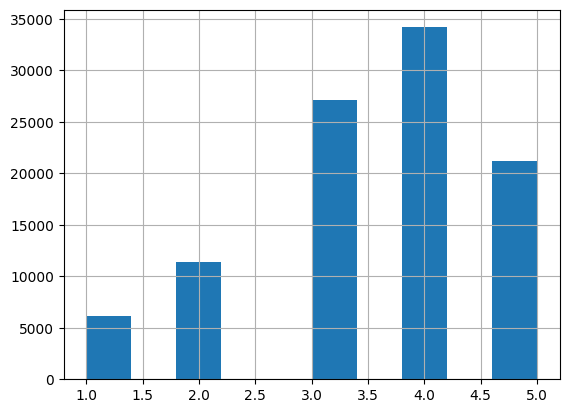

In [11]:
df["rating"].hist()

## User-item Matrix <a id="matrix"></a>

The first step to create a recommender system, is to transform the dataset into a user-item matrix. To that end, we must first define the "user", the "item" and the "value". The value can be a rating (explicit feedback) or binary information (implicit feedback).

In this case, our user is the column "user", the item is the "item" and the value is the "rating".

### Pandas version <a id="pandas"></a>

Let's create a user-item matrix based on our pandas dataframe.

In [12]:
# we will use the pivot function
df_matrix = df.pivot(index='user_id', columns='item_id', values='rating')

df_matrix

item_id,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Is this dataset sparse?

To calculate the sparsity, we count the number of ratings (that is, the number of cells in the matrix that are filled) and divide by the total number of user-item pairs. To count the number of users, we can simply count the number of rows in the matrix, while to count the number of items, we can simply count the number of columns. 

In [13]:
print(f"{df_matrix.notnull().sum().sum() / (df_matrix.shape[0] * df_matrix.shape[1]):.2%}")

6.30%


What is the:

1. distribution of total number of items per user?

2. distribution of total number of users per item?

3. distribution of mean ratings per user?

4. distribution of ratings?

(Show the histograms)

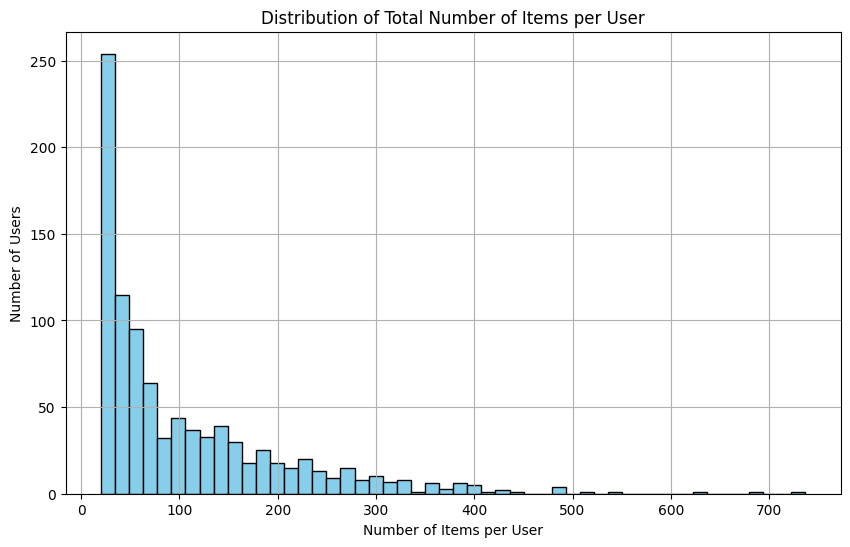

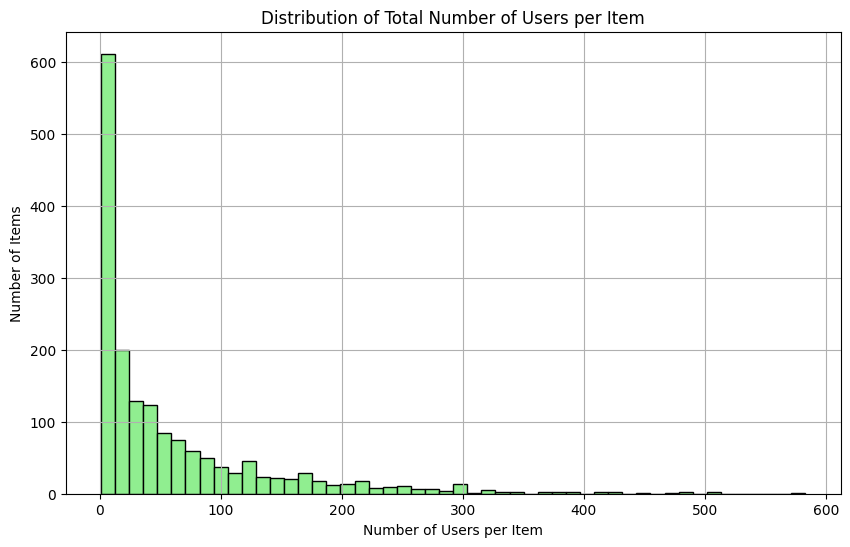

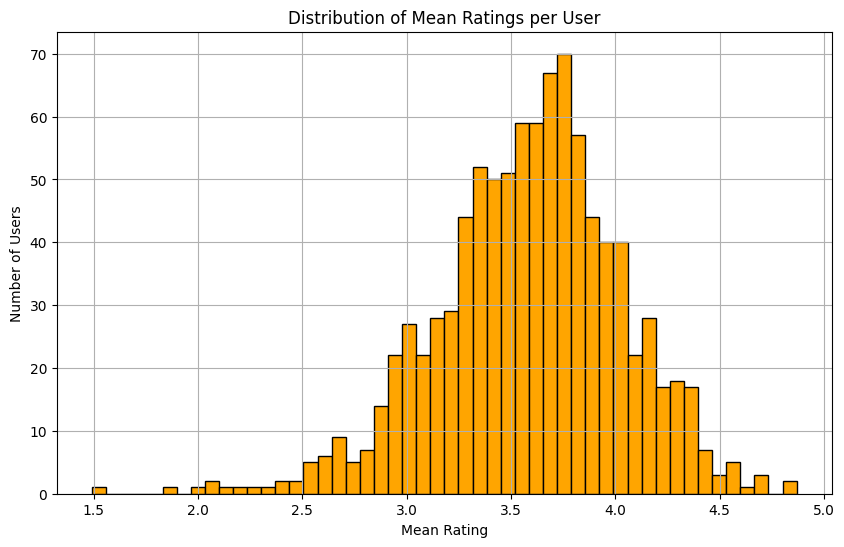

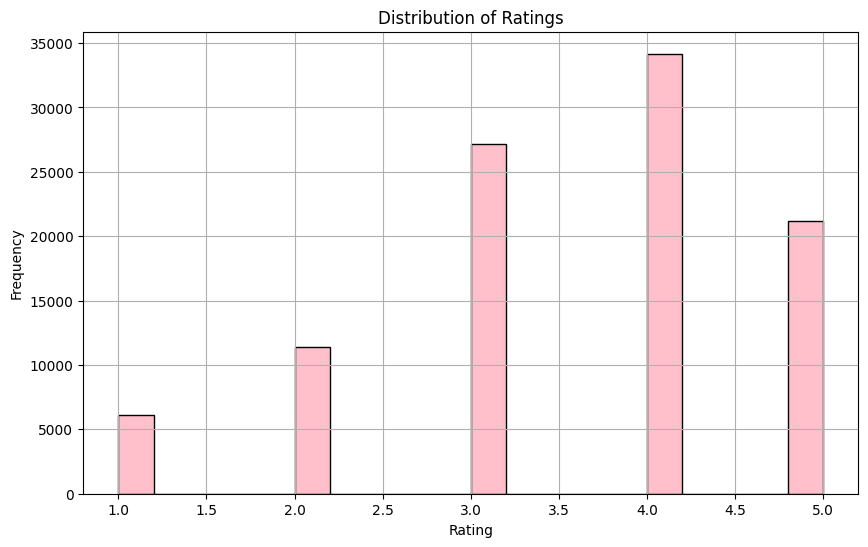

In [14]:
import matplotlib.pyplot as plt

# 1. Distribution of total number of items per user
items_per_user = df_matrix.notnull().sum(axis=1)
plt.figure(figsize=(10, 6))
plt.hist(items_per_user, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Number of Items per User')
plt.xlabel('Number of Items per User')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()

# 2. Distribution of total number of users per item
users_per_item = df_matrix.notnull().sum()
plt.figure(figsize=(10, 6))
plt.hist(users_per_item, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribution of Total Number of Users per Item')
plt.xlabel('Number of Users per Item')
plt.ylabel('Number of Items')
plt.grid(True)
plt.show()

# 3. Distribution of mean ratings per user
mean_ratings_per_user = df_matrix.mean(axis=1)
plt.figure(figsize=(10, 6))
plt.hist(mean_ratings_per_user, bins=50, color='orange', edgecolor='black')
plt.title('Distribution of Mean Ratings per User')
plt.xlabel('Mean Rating')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()

# 4. Distribution of ratings
ratings = df['rating']
plt.figure(figsize=(10, 6))
plt.hist(ratings, bins=20, color='pink', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Surprise Library <a id="surprise"></a>

Now let's tranform dataset in a user-item matrix **using the surprise library**.

To that end, we can apply the method "build_full_trainset".

This is the documentation for the trainset object https://surprise.readthedocs.io/en/stable/trainset.html

(Using the trainset object is useful for applying the surprise library methods)

In [15]:
# Build the trainset
data = Dataset.load_builtin('ml-100k')
reader = Reader(rating_scale=(1, 5))

trainset = data.build_full_trainset()

trainset

Explore the trainset object. 

Can you answer the same questions about the dataset using only the methods available in the trainset object? Do you have the same results?

In [16]:
items_per_user = [len(trainset.ur[user_id]) for user_id in trainset.all_users()]
print(f"Average number of items per user: {np.mean(items_per_user):.2f}")

users_per_item = [len(trainset.ir[item_id]) for item_id in trainset.all_items()]
print(f"Average number of users per item: {np.mean(users_per_item):.2f}")

mean_ratings_per_user = [np.mean([rating for (_, rating) in trainset.ur[user_id]]) for user_id in trainset.all_users()]
print(f"Average mean ratings per user: {np.mean(mean_ratings_per_user):.2f}")

ratings_distribution = [rating for (_, _, rating) in trainset.all_ratings()]
print(f"Average rating: {np.mean(ratings_distribution):.2f}")

Average number of items per user: 106.04
Average number of users per item: 59.45
Average mean ratings per user: 3.59
Average rating: 3.53


What are the two most popular items?

In [17]:
from collections import Counter

item_ratings_count = Counter([len(trainset.ir[item_id]) for item_id in trainset.all_items()])

most_popular_items = item_ratings_count.most_common(2)

print("The two most popular items are:")
for item_id, count in most_popular_items:
    print(f"Item ID: {item_id}, Number of Ratings: {count}")

The two most popular items are:
Item ID: 1, Number of Ratings: 141
Item ID: 2, Number of Ratings: 68


## Recommender Systems <a id="recsys"></a>

In [18]:
# HACK: the dataset is too big, so we will pick or pandas dataframe, create a sample and then covert to the surprise lib dataset
reader = Reader(rating_scale=(df.rating.min(), df.rating.max()))
# you can try other sizes
size = 10000
data_sml = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']].sample(size), reader)

To properly evaluate the recommender systems, we will now split the original dataset into train and test. 

In [19]:
# use only the first half of the dataset as our dataset
# split intro train and test set
trainset, testset = train_test_split(data, test_size=0.2)

### Popularity <id a="popularity"></a>

The popularity method is the simplest recommender system.

It finds the most popular items and then recommends them to new users.

In [20]:
# Popular Recommender -> maybe we should use the rating too
def popular_recommendations(trainset, top_n=10):
    item_counts = defaultdict(int)

    # Iterate through the trainset to count item ratings
    for _, item_id, _ in trainset.all_ratings():
        item_counts[item_id] += 1

    # Sort items by popularity (number of ratings)
    popular_items = sorted(item_counts.items(), key=lambda x: x[1], reverse=True)

    # Get the top N most popular items (e.g., top 10)
    top_n = popular_items[:top_n]
    return [trainset.to_raw_iid(i) for i, _ in top_n]

These are the most popular items

In [21]:
popular_recommendations(trainset, 5)

['50', '258', '181', '100', '294']

### Modelling <a id="modelling"></a>

The predictor fills the matrix with the ratings por unseen user-item pairs.

To evaluate how good the model is, we calculate the RMSE between the true value and the predicted. 

As we are using the test set to create the predictions only for user-item pairs found in the test set.

In [22]:
# Define evaluation function
def evaluate_algorithm(algo, trainset, testset):
    algo.fit(trainset)
    predictions = algo.test(testset)
    
    # Compute and return RMSE
    rmse = accuracy.rmse(predictions)
    return rmse

In [23]:
# Random Recommender
random_algo = NormalPredictor()
random_rmse = evaluate_algorithm(random_algo, trainset, testset)

RMSE: 1.5171


In [24]:
# User-Based Collaborative Filtering
#ubcf_algo = KNNBasic(sim_options={'user_based': True})
#ubcf_rmse = evaluate_algorithm(ubcf_algo, trainset, testset)

In [25]:
# Item-Based Collaborative Filtering
ibcf_algo = KNNBasic(sim_options={'user_based': False})
ibcf_rmse = evaluate_algorithm(ibcf_algo, trainset, testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9665


In [26]:
# Singular Value Decomposition (SVD)
svd_algo = SVD()
svd_rmse = evaluate_algorithm(svd_algo, trainset, testset)

RMSE: 0.9288


In [27]:
print(f"Random RMSE: {random_rmse:.3f}")
#print(f"User-Based CF RMSE: {ubcf_rmse:.3f}")
print(f"Item-Based CF RMSE: {ibcf_rmse:.3f}")
print(f"SVD RMSE: {svd_rmse:.3f}")

Random RMSE: 1.517
Item-Based CF RMSE: 0.966
SVD RMSE: 0.929


### Top recommendations <a id="top-rec"></a>

The following function is designed to generate personalized recommendations for a user using a recommender model (`algo`) and a `Trainset` object. It uses the recommender model to make a rating prediction for each item the user hasn't interacted with and sorts the items by their estimated scores in descending order. Then, selects the top `n` items with the highest estimated scores as recommendations for the user.

In [28]:
# Recommend top N items for a user using a recommender model
def recommend_top_n(algo, trainset, user_id, n=10):
    user_ratings = trainset.ur[user_id]
    items = [item_id for (item_id, _) in user_ratings]
    
    item_scores = {}
    # this is actually not the most correct way to do this, but it works
    for item_id in trainset.all_items():
        if item_id not in items:
            prediction = algo.predict(trainset.to_raw_uid(user_id), trainset.to_raw_iid(item_id), verbose=True)
            item_scores[item_id] = prediction.est
    
    top_items = sorted(item_scores, key=item_scores.get, reverse=True)[:n]

    #from raw_id to actual_id
    return [trainset.to_raw_iid(i) for i in top_items]

In [29]:
# Get recommendations for a specific user using the User-Based CF model
user_id = 3 # Change to the desired user ID
ubcf_top_items = recommend_top_n(ibcf_algo, trainset, user_id , n=5)
print("Top 5 User-Based CF Recommendations for User", trainset.to_raw_uid(user_id), ":", ubcf_top_items)

user: 886        item: 203        r_ui = None   est = 3.70   {'actual_k': 40, 'was_impossible': False}
user: 886        item: 284        r_ui = None   est = 3.43   {'actual_k': 40, 'was_impossible': False}
user: 886        item: 12         r_ui = None   est = 3.97   {'actual_k': 40, 'was_impossible': False}
user: 886        item: 421        r_ui = None   est = 3.42   {'actual_k': 40, 'was_impossible': False}
user: 886        item: 190        r_ui = None   est = 4.03   {'actual_k': 40, 'was_impossible': False}
user: 886        item: 942        r_ui = None   est = 3.34   {'actual_k': 40, 'was_impossible': False}
user: 886        item: 981        r_ui = None   est = 3.32   {'actual_k': 40, 'was_impossible': False}
user: 886        item: 468        r_ui = None   est = 3.07   {'actual_k': 40, 'was_impossible': False}
user: 886        item: 538        r_ui = None   est = 3.56   {'actual_k': 40, 'was_impossible': False}
user: 886        item: 678        r_ui = None   est = 2.69   {'actual_k':

In [30]:
user_id = 10
n = 5
print("user_id", trainset.to_raw_uid(user_id))

#print(recommend_top_n(ubcf_algo, trainset, user_id, n))
print(recommend_top_n(svd_algo, trainset, user_id, n))

user_id 280
user: 280        item: 284        r_ui = None   est = 3.33   {'was_impossible': False}
user: 280        item: 421        r_ui = None   est = 3.69   {'was_impossible': False}
user: 280        item: 190        r_ui = None   est = 4.13   {'was_impossible': False}
user: 280        item: 942        r_ui = None   est = 3.54   {'was_impossible': False}
user: 280        item: 981        r_ui = None   est = 3.05   {'was_impossible': False}
user: 280        item: 468        r_ui = None   est = 3.79   {'was_impossible': False}
user: 280        item: 208        r_ui = None   est = 3.79   {'was_impossible': False}
user: 280        item: 484        r_ui = None   est = 4.16   {'was_impossible': False}
user: 280        item: 52         r_ui = None   est = 4.46   {'was_impossible': False}
user: 280        item: 14         r_ui = None   est = 4.71   {'was_impossible': False}
user: 280        item: 168        r_ui = None   est = 4.11   {'was_impossible': False}
user: 280        item: 662     

How to evaluate this ranking?

In [31]:
df_testset = pd.DataFrame(testset, columns=['user_id', 'item_id', 'rating'])

In [32]:
df_testset.groupby("user_id").apply(len).value_counts()

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_32888\1466945760.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_testset.groupby("user_id").apply(len).value_counts()


7     61
5     51
8     51
4     50
6     49
      ..
87     1
79     1
75     1
89     1
63     1
Name: count, Length: 87, dtype: int64

In [33]:
# we just want to recommend positive ratings
pos_rating = 5
df_testset_pos = df_testset[df_testset["rating"] > pos_rating]
# which users exist in the training and testset
users = []
for u in df_testset_pos["user_id"].unique():
    try :
        trainset.to_inner_uid(u)
        users.append(u)
    except ValueError:
        continue

print("number of users in the testset that exist in the trainset:", len(users))

number of users in the testset that exist in the trainset: 0


In [ ]:
random_user = random.choice(users)
n = 5
print("user_id : ", random_user)
gt = df_testset[(df_testset['user_id']==random_user) & (df_testset['rating']>pos_rating)].item_id.to_list()
print("ground truth : ", gt)
recs =  recommend_top_n(svd_algo, trainset, trainset.to_inner_uid(random_user), n)
print("recommendations: ",recs)
print(f"hits: {len(set(gt).intersection(set(recs)))} / {n}")